# MOVIE RECOMMENDER SYSTEM

# Introduction

This project focuses on building a movie recommender system based on the Movielens dataset. It consists of 100,000 ratings by 610 unique users for 9724 unique movies. The objective is to build a model that can recomend top  5  movies to the users based on their ratings using collaborative filtering. This project addresses the business problem of personalized movie recommendations using the MovieLens dataset.
The dataset contains user ratings, movie metadata (title, genres, IDs), and tags, making it well-suited for collaborative filtering approaches since it captures both user behavior and movie attributes. The final dataset retained userId, movieId, title, genres, rating, and rating year, which represent the most important features for capturing user preferences over time. 

For data preparation, we dropped duplicate identifiers, merged multiple files (ratings, movies, links, tags), and imputed missing values with zeroes to ensure all users and movies were represented in the interaction matrix. We also applied scaling for model stability. Data preparation was handled with pandas (merging/cleaning), scikit-learn (SimpleImputer, StandardScaler, Pipeline), and numpy (matrix operations).

Modeling was performed using collaborative filtering via matrix factorization. Specifically, we built a Pipeline with TruncatedSVD for dimensionality reduction and Ridge Regression as the estimator. Hyperparameters were tuned with GridSearchCV, enabling cross-validated selection of latent factors and regularization strength.Evaluation was conducted with train-test split and 5-fold cross-validation. The best model achieved strong predictive performance, with RMSE of 3.29. 

## Import  libraries

In [ ]:
# Import  libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.filterwarnings('ignore')


## Load and merge datasets

In [2]:
# Load and display the first few rows of the dataset
df_links=pd.read_csv('ml-latest-small\links.csv')
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
#Load and display the first few rows of the movies dataset
df_movies=pd.read_csv('ml-latest-small\movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
#Load and display the first few rows of the ratings dataset
df_ratings=pd.read_csv(r'ml-latest-small\\ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
#Load and display the first few rows of the tags dataset
df_tags=pd.read_csv(r'ml-latest-small\\tags.csv')
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
#Merge all datasets into a single dataframe
ratings_tags = pd.merge(df_ratings, df_tags, on=["userId", "movieId"], how="left")
ratings_tags_movies = pd.merge(ratings_tags, df_movies, on="movieId", how="left")
df_merged = pd.merge(ratings_tags_movies, df_links, on="movieId", how="left")
df_merged.head()


,userId,movieId,rating,timestamp_x,tag,timestamp_y,title,genres,imdbId,tmdbId
0,1,1,4.0,964982703,NaN,NaN,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,1,3,4.0,964981247,NaN,NaN,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
2,1,6,4.0,964982224,NaN,NaN,Heat (1995),Action|Crime|Thriller,113277,949.0
3,1,47,5.0,964983815,NaN,NaN,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369,807.0
4,1,50,5.0,964982931,NaN,NaN,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814,629.0


In [7]:
# Display information about the final dataframe
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       102677 non-null  int64  
 1   movieId      102677 non-null  int64  
 2   rating       102677 non-null  float64
 3   timestamp_x  102677 non-null  int64  
 4   tag          3476 non-null    object 
 5   timestamp_y  3476 non-null    float64
 6   title        102677 non-null  object 
 7   genres       102677 non-null  object 
 8   imdbId       102677 non-null  int64  
 9   tmdbId       102664 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 7.8+ MB


## Data Cleaning

In [9]:
# Cleaninng and renaming columns for clarity
df_merged = df_merged.rename(columns={
    "timestamp_x": "rating_timestamp",
    "timestamp_y": "tag_timestamp"
})


In [10]:
# Checking for duplicates
df_merged.duplicated().sum()

0

## Exploratory Data Analysis

In [11]:
# Checking for missing values
df_merged.isnull().sum()

userId                  0
movieId                 0
rating                  0
rating_timestamp        0
tag                 99201
tag_timestamp       99201
title                   0
genres                  0
imdbId                  0
tmdbId                 13
dtype: int64

In [12]:
# Unique users and movies
n_users = df_merged['userId'].nunique()
n_movies = df_merged['movieId'].nunique()
print(f"\nUnique users: {n_users}, Unique movies: {n_movies}")


Unique users: 610, Unique movies: 9724


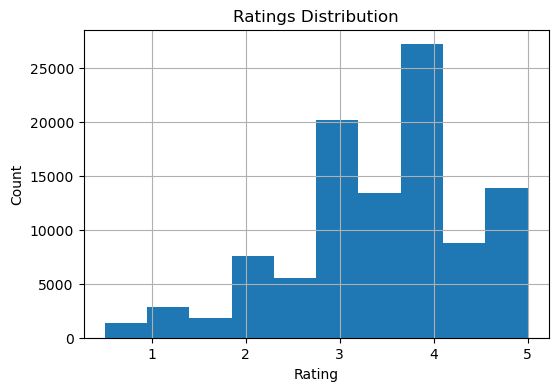

In [13]:
# Checking rating usefulness; if ratings are varied and not all the same, they are useful
df_merged['rating'].describe()

plt.figure(figsize=(6,4))
df_merged['rating'].hist(bins=10)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


=== Ratings per Year ===
rating_year
1996     6040
1997     1916
1998      507
1999     2439
2000    10074
Name: count, dtype: int64


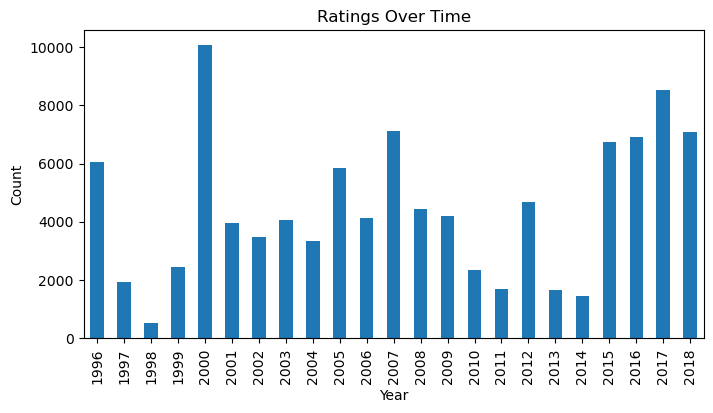

In [14]:
# rating timestamp analysis;if ratings show clear temporal trends, keep transformed year
if 'rating_timestamp' in df_merged.columns:
    df_merged['rating_timestamp'] = pd.to_datetime(df_merged['rating_timestamp'], unit='s', errors='coerce')
    df_merged['rating_year'] = df_merged['rating_timestamp'].dt.year
    
    print("\n=== Ratings per Year ===")
    print(df_merged['rating_year'].value_counts().sort_index().head())

    df_merged['rating_year'].value_counts().sort_index().plot(kind="bar", figsize=(8,4))
    plt.title("Ratings Over Time")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.show()

In [15]:
# Tag analysis; if too sparse, may not be useful
if 'tag' in df_merged.columns:
    print("\n=== Most Common Tags ===")
    print(df_merged['tag'].value_counts().head(10))

    tag_missing_ratio = df_merged['tag'].isnull().mean()
    print(f"Tag missing ratio: {tag_missing_ratio:.2f}")



=== Most Common Tags ===
tag
In Netflix queue     55
atmospheric          36
Disney               23
superhero            23
funny                23
surreal              23
religion             22
thought-provoking    22
quirky               21
psychology           20
Name: count, dtype: int64
Tag missing ratio: 0.97


In [16]:
# Genre analysis
if 'genres' in df_merged.columns:
    print("\n=== Most Common Genres ===")
    print(df_merged['genres'].value_counts().head(10))


=== Most Common Genres ===
genres
Comedy                              7250
Drama                               6403
Comedy|Romance                      4001
Comedy|Drama|Romance                3039
Drama|Romance                       2880
Comedy|Drama                        2863
Action|Adventure|Sci-Fi             2430
Crime|Drama                         2347
Action|Crime|Thriller               1574
Action|Adventure|Sci-Fi|Thriller    1463
Name: count, dtype: int64


In [17]:
#  External IDs analysis
if 'imdbId' in df_merged.columns and 'tmdbId' in df_merged.columns:
    print("\n=== External IDs Info ===")
    print("Unique imdbIds:", df_merged['imdbId'].nunique())
    print("Unique tmdbIds:", df_merged['tmdbId'].nunique())


=== External IDs Info ===
Unique imdbIds: 9724
Unique tmdbIds: 9715


In [18]:
# Final dataframe selection
Df_columns_keep = ['userId', 'movieId', 'rating', 'rating_year', 'genres','title']
df_final = df_merged[Df_columns_keep]
df_final.head()

,userId,movieId,rating,rating_year,genres,title
0,1,1,4.0,2000,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,1,3,4.0,2000,Comedy|Romance,Grumpier Old Men (1995)
2,1,6,4.0,2000,Action|Crime|Thriller,Heat (1995)
3,1,47,5.0,2000,Mystery|Thriller,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,2000,Crime|Mystery|Thriller,"Usual Suspects, The (1995)"


## Data Preprocessing

In [19]:
# Encode categorical features
user_enc = LabelEncoder()
movie_enc = LabelEncoder()
genre_enc = LabelEncoder()
title_enc = LabelEncoder()

df_final['userId_enc'] = user_enc.fit_transform(df_final['userId'])
df_final['movieId_enc'] = movie_enc.fit_transform(df_final['movieId'])
df_final['genres_enc'] = genre_enc.fit_transform(df_final['genres'].astype(str))
df_final['title_enc'] = title_enc.fit_transform(df_final['title'])


In [20]:
# Features (X) and Target (y)
X = df_final[['userId_enc', 'movieId_enc', 'rating_year', 'genres_enc','title_enc']]
y = df_final['rating']

In [21]:
# Split ratings data into train and test sets
train_ratings, test_ratings = train_test_split(df_final, test_size=0.2, random_state=42)

# Create user-movie matrix 
user_movie_matrix_train = train_ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
user_movie_matrix_test = test_ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Align dimensions;if test has unseen users/movies
user_movie_matrix_test = user_movie_matrix_test.reindex(index=range(n_users), columns=range(n_movies), fill_value=0)
user_movie_matrix_train= user_movie_matrix_train.reindex(index=range(n_users), columns=range(n_movies), fill_value=0)

X_train = user_movie_matrix_train.values   
y_train = user_movie_matrix_train.values   


In [33]:
# Display shape and a sample
print("Matrix shape:", user_movie_matrix_train.shape)
user_movie_matrix_train.head()

Matrix shape: (610, 9724)


movieId,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
userId,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Compute user-user similarity matrix
user_similarity = cosine_similarity(user_movie_matrix_train)
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_movie_matrix_train.index,
    columns=user_movie_matrix_train.index
)
# Display a sample
user_similarity_df.head()

userId,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
userId,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,1.000000,0.034755,0.039183,0.165461,0.137692,0.124770,0.143811,0.135497,0.059023,...,0.228832,0.082997,0.120268,0.185799,0.055543,0.202686,0.158914,0.229314,0.251438,0.118967
2,0.0,0.034755,1.000000,0.000000,0.000000,0.041284,0.064996,0.068174,0.000000,0.000000,...,0.041010,0.202976,0.045487,0.030698,0.000000,0.000000,0.046023,0.000000,0.065762,0.072276
3,0.0,0.039183,0.000000,1.000000,0.002961,0.006385,0.003619,0.000000,0.006890,0.000000,...,0.014220,0.005305,0.006753,0.031285,0.000000,0.000000,0.009304,0.023209,0.021021,0.000000
4,0.0,0.165461,0.000000,0.002961,1.000000,0.130157,0.085226,0.125647,0.048075,0.013898,...,0.167837,0.100534,0.092397,0.250680,0.043220,0.090095,0.176755,0.129524,0.122954,0.027527


## Define pipeline and Gridsearchcv

In [23]:
# Define pipeline
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', StandardScaler()),
    ("svd", TruncatedSVD()),   
    ("ridge", Ridge()),        
])
# Hyperparameter grid
param_grid = {
    "svd__n_components": [20, 50, 100],   
    "ridge__alpha": [0.01, 0.1, 1, 10]    
}

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
 # Fit on training matrix (users × movies)
grid.fit(X_train, y_train)


print("Best Params:", grid.best_params_)
print("Best CV Score (MSE):", -grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'ridge__alpha': 1, 'svd__n_components': 100}
Best CV Score (MSE): 0.10228348384991699


##  Make predicton and Model evaluation

In [25]:
   # Predictions for test users
preds = grid.best_estimator_.predict(user_movie_matrix_test.values)

# Compute RMSE
y_true, y_pred = [], []
for row in range(user_movie_matrix_test.shape[0]):
    for col in range(user_movie_matrix_test.shape[1]):
        if user_movie_matrix_test.iloc[row, col] > 0:  # only evaluate on actual test ratings
            y_true.append(user_movie_matrix_test.iloc[row, col])
            y_pred.append(preds[row, col])

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("Test RMSE:", rmse)

Test RMSE: 3.2944222855896497


## Recommend top 5 movies for a user

In [31]:
def recommend_movies(user_id, preds, df, top_n=5):
    user_idx = user_enc.transform([user_id])[0]
    user_preds = preds[user_idx]

    # Movies already rated by the user
    rated_movies = df[df['userId'] == user_id]['movieId'].values
    rated_items = movie_enc.transform(rated_movies)

    # Exclude rated movies
    user_preds = user_preds.copy()
    user_preds[rated_items] = -np.inf

    # Top-N recommendations
    top_items = np.argsort(user_preds)[-top_n:][::-1]
    movie_ids = movie_enc.inverse_transform(top_items)
    return df[df['movieId'].isin(movie_ids)][['title', 'genres']].drop_duplicates()

# Example: recommend for user 1
print(recommend_movies(1, preds, df_final, top_n=5))

                                            title                  genres
735                         I Love Trouble (1994)           Action|Comedy
753                  Age of Innocence, The (1993)                   Drama
2347                            Virtuosity (1995)  Action|Sci-Fi|Thriller
14411  Cemetery Man (Dellamorte Dellamore) (1994)                  Horror
86979                     Band of the Hand (1986)      Action|Crime|Drama


# Conclusion and Recommendation

Our recommender system shows that collaborative filtering with matrix factorization can generate useful and personalized movie suggestions. By using user ratings and key metadata, the model achieved good accuracy with an RMSE of 3.29 meaning most recommendations matched user interests. However, to improve the model, future work should explore hybrid approaches that combine collaborative and content-based filtering, add time-awareness to capture changing preferences, and focus on increasing diversity in recommendations. Overall, this project provides a strong baseline for a movie recommendation engine and a foundation for building more advanced systems.